In [1]:
import matplotlib.pyplot as plt
import scipy
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.io import fits
import lightkurve as lk
plt.rcParams.update({'font.size': 18})
plt.style.use('vedant')
import sys
sys.path.append('../../WD_models/')
from sed_fitter import FitSED
from tqdm import tqdm
from scipy import stats
import glob

In [2]:
from astroquery.skyview import SkyView

# Sky Images

In [3]:
from astropy import units as u
from astropy.wcs import WCS
from astropy.io import fits

In [8]:
SkyView.survey_dict

{'GammaRay': ['Fermi 5',
  'Fermi 4',
  'Fermi 3',
  'Fermi 2',
  'Fermi 1',
  'EGRET (3D)',
  'EGRET <100 MeV',
  'EGRET >100 MeV',
  'COMPTEL'],
 'HardX-ray': ['INT GAL 17-35 Flux',
  'INT GAL 17-60 Flux',
  'INT GAL 35-80 Flux',
  'INTEGRAL/SPI GC',
  'GRANAT/SIGMA',
  'RXTE Allsky 3-8keV Flux',
  'RXTE Allsky 3-20keV Flux',
  'RXTE Allsky 8-20keV Flux'],
 'X-ray:SwiftBAT': ['BAT SNR 14-195',
  'BAT SNR 14-20',
  'BAT SNR 20-24',
  'BAT SNR 24-35',
  'BAT SNR 35-50',
  'BAT SNR 50-75',
  'BAT SNR 75-100',
  'BAT SNR 100-150',
  'BAT SNR 150-195'],
 'SoftX-ray class=': ['SwiftXRTCnt',
  'SwiftXRTExp',
  'SwiftXRTInt',
  'HEAO 1 A-2'],
 'ROSATw/sources class=': ['RASS-Cnt Soft',
  'RASS-Cnt Hard',
  'RASS-Cnt Broad',
  'PSPC 2.0 Deg-Int',
  'PSPC 1.0 Deg-Int',
  'PSPC 0.6 Deg-Int',
  'HRI'],
 'ROSATDiffuse class=': ['RASS Background 1',
  'RASS Background 2',
  'RASS Background 3',
  'RASS Background 4',
  'RASS Background 5',
  'RASS Background 6',
  'RASS Background 7'],
 'UV': ['GA

In [15]:
a = 30

pos = '324.612306 25.373458'
ra = (324.612306 * u.degree).to(u.arcsec)

paths = SkyView.get_images(position=pos, survey=['CFHTLS-W-g'], width = a * u.arcsec, height = a*u.arcsec)
sdss = paths[0][0]
sdss_wcs = WCS(sdss.header)

paths = SkyView.get_images(position=pos, survey=['WISE 3.4'], width = a * u.arcsec, height = a*u.arcsec)
wise = paths[0][0]
wise_wcs = WCS(sdss.header)

paths = SkyView.get_images(position=pos, survey=['2MASS-J'], 
                           width = a * u.arcsec, height = a*u.arcsec)
vista = paths[0][0]
vista_wcs = WCS(sdss.header)

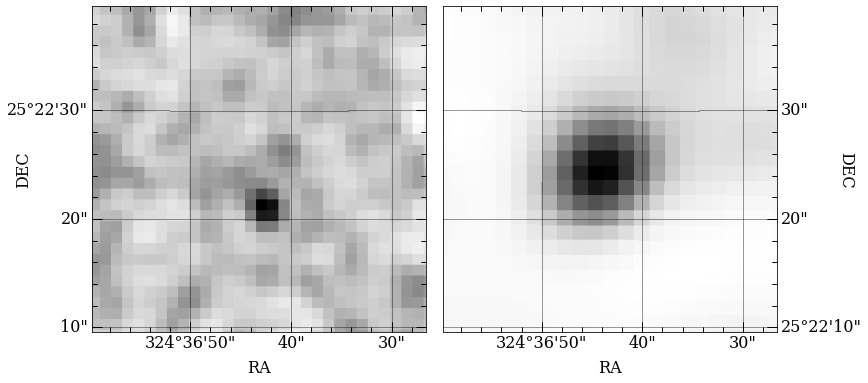

In [17]:
plt.figure(figsize = (10, 5))

# 2MASS AND WISE PHOTOS


ax = plt.subplot(121, projection = vista_wcs)


ax.imshow(vista.data, cmap = 'Greys', origin = 'lower')
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('dd:mm:ss')
lat.set_major_formatter('dd:mm:ss')
lon.set_ticks(spacing=10 * u.arcsec, color='k')
lat.set_ticks(spacing=10 * u.arcsec, color='k')
lon.set_ticklabel(exclude_overlapping=True)
lat.set_ticklabel(exclude_overlapping=True)
lon.set_axislabel('RA')
lat.set_axislabel('DEC', minpad = -1)
ax.coords.grid(color='k', alpha=0.5, linestyle='solid')

ax = plt.subplot(122, projection = wise_wcs)

ax.imshow(wise.data, cmap = 'Greys', origin = 'lower')
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('dd:mm:ss')
lat.set_major_formatter('dd:mm:ss')
lon.set_ticks(spacing=10 * u.arcsec, color='k')
lat.set_ticks(spacing=10 * u.arcsec, color='k')
lon.set_ticklabel(exclude_overlapping=True)
lat.set_ticklabel(exclude_overlapping=True)
lat.set_ticks_position('r')
lat.set_ticklabel_position('r')
lat.set_axislabel_position('r')
lon.set_axislabel('RA')
lat.set_axislabel('DEC', minpad = -1)
ax.coords.grid(color='k', alpha=0.5, linestyle='solid')


plt.tight_layout()
plt.savefig('fig/d62_img.pdf', bbox_inches = 'tight')

# Hipercam Data

In [18]:
files = glob.glob('./hipercam-data/*')
files

['./hipercam-data/hipercam-i.dat',
 './hipercam-data/int-g.dat',
 './hipercam-data/hipercam-z.dat',
 './hipercam-data/hipercam-u.dat',
 './hipercam-data/hipercam-g.dat',
 './hipercam-data/hipercam-r.dat']

In [19]:
data = {};
lcs = {};
bands = 'u.g.r.i.z'.split('.')
mjds = [];

for band in bands:
    dat = np.loadtxt('./hipercam-data/hipercam-%s.dat' % band).T
    mjd = dat[0]
    mag = dat[2]
    e_mag = dat[3]
    mask = dat[4]
    
    mjds.extend(mjd)
    
    mins = (mjd - np.min(mjd)) * 24 * 60
    
    data[band] = np.vstack((mins, mag, e_mag)).T
    lcs[band] = lk.LightCurve(time = mins, flux = mag, flux_err = e_mag)

In [24]:
dat = np.loadtxt('./hipercam-data/int-g.dat').T

print(dat[0].min())
print(dat[0].max())

fl = -2.5 * np.log10(dat[2])
e_fl = dat[3] * fl

int_lc = lk.LightCurve(time = dat[0], flux = fl, flux_err = e_fl)

reg = stats.linregress(dat[0], fl)

58332.00773313333
58332.20974685092


In [25]:
color_dict = dict(u = 'blueviolet',
                 g = 'royalblue',
                 r = 'seagreen',
                 i = 'coral',
                 z = 'tab:red'
)

In [26]:
from ltsfit.lts_linefit import lts_linefit

sig_int:     0.0000     -0.1205
No intrinsic scatter or errors overestimated
Repeat at best fitting solution
sig_int:     0.0000     -0.1205
################# Values and formal errors ################
 intercept:  18.87 +/- 0.51
     slope:  0.365 +/- 0.011
   scatter:  0. +/- 0.0
Observed rms scatter: 0.0092
y = a + b*(x - pivot) with pivot = 48.68
Spearman r=0.6 and p=3.9e-236
Pearson r=0.6 and p=7.6e-233
##########################################################
seconds 1.89


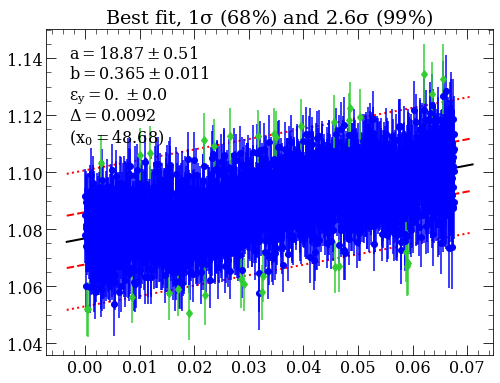

sig_int:     0.0000     -0.0350
No intrinsic scatter or errors overestimated
Repeat at best fitting solution
sig_int:     0.0000     -0.0350
################# Values and formal errors ################
 intercept:  16.60 +/- 0.19
     slope:  0.3051 +/- 0.0039
   scatter:  0. +/- 0.0
Observed rms scatter: 0.0050
y = a + b*(x - pivot) with pivot = 48.7
Spearman r=0.76 and p=0
Pearson r=0.75 and p=0
##########################################################
seconds 2.66


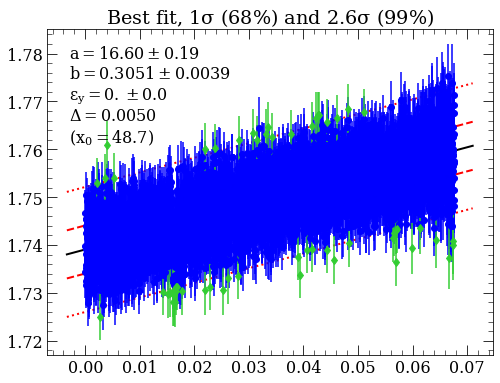

sig_int:     0.0000     -0.1413
No intrinsic scatter or errors overestimated
Repeat at best fitting solution
sig_int:     0.0000     -0.1413
################# Values and formal errors ################
 intercept:  16.37 +/- 0.20
     slope:  0.2949 +/- 0.0042
   scatter:  0. +/- 0.0
Observed rms scatter: 0.0051
y = a + b*(x - pivot) with pivot = 48.7
Spearman r=0.74 and p=0
Pearson r=0.73 and p=0
##########################################################
seconds 2.71


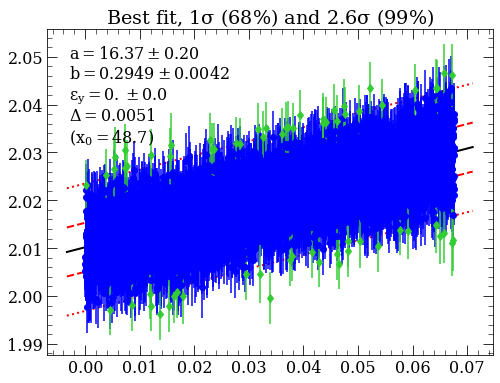

sig_int:     0.0000     -0.0848
No intrinsic scatter or errors overestimated
Repeat at best fitting solution
sig_int:     0.0000     -0.0848
################# Values and formal errors ################
 intercept:  13.67 +/- 0.26
     slope:  0.2349 +/- 0.0053
   scatter:  0. +/- 0.0
Observed rms scatter: 0.0067
y = a + b*(x - pivot) with pivot = 48.7
Spearman r=0.54 and p=0
Pearson r=0.53 and p=0
##########################################################
seconds 2.73


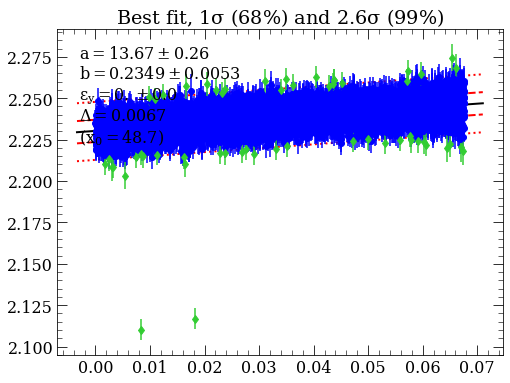

sig_int:     0.0000     -0.0337
No intrinsic scatter or errors overestimated
Repeat at best fitting solution
sig_int:     0.0000     -0.0337
################# Values and formal errors ################
 intercept:  10.38 +/- 0.39
     slope:  0.1644 +/- 0.0080
   scatter:  0. +/- 0.0
Observed rms scatter: 0.0075
y = a + b*(x - pivot) with pivot = 48.68
Spearman r=0.37 and p=4.6e-77
Pearson r=0.36 and p=7.3e-76
##########################################################
seconds 1.78


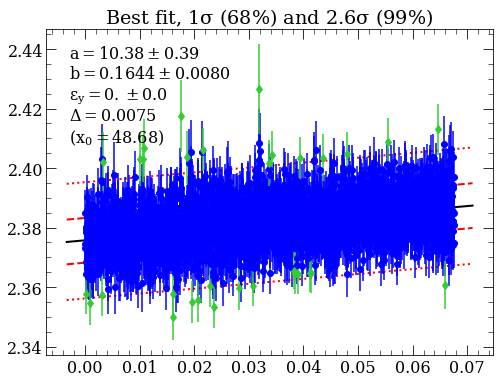

In [28]:
slopes = [];
e_slopes = [];

for ii,band in enumerate(bands):
    lc = lcs[band]
    p = lts_linefit(lc.time.value / (60 * 24), lc.flux.value, np.repeat(0, 
                        len(lc.time.value)), lc.flux_err.value, plot = True,
                   corr = False, pivot = np.mean(lc.time.value))
    plt.autoscale()
    plt.show()
    
    slopes.append(p.ab[1])
    e_slopes.append(p.ab_err[1])

Text(0, 0.5, 'Magnitude + Constant')

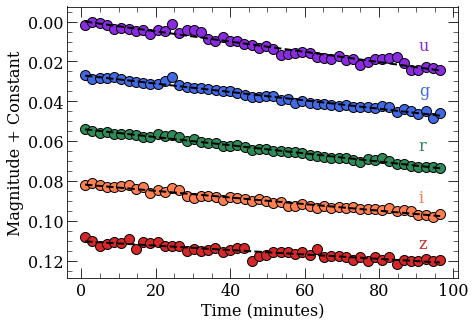

In [32]:
binf = 50
gap = 0.027
tgaps = [0.0, 0.165, 0.37, 0.56, 0.73]

f = plt.figure(figsize = (7, 5))
ax1 = plt.gca()

for ii,band in enumerate(bands):
    
    lc = lcs[band]
    
#     if band == 'u' or band == 'z':
#         bin_f = int(binf/2)
#     else:
#         bin_f = binf
    
    binned_lc = lc.bin(bins = binf)
    
    fl_norm = binned_lc.flux.value - np.min(binned_lc.flux).value
    e_fl_norm = binned_lc.flux_err.value #- np.median(binned_lc.flux)
    
    ax1.errorbar(
        binned_lc.time.value, 
        fl_norm + gap*ii,
        yerr = e_fl_norm,
        linestyle = 'none', marker = 'o', ecolor = 'k', 
        color = color_dict[band], capsize = 0, elinewidth = 1,
        mec = 'k', mew = 1, markersize = 10, alpha = 1
    )
    
    reg = stats.linregress(lc.time.value/(60 * 24), lc.flux.value)
    m = slopes[ii]
    reg = stats.linregress(binned_lc.time.value, fl_norm)
    
    angle = 0
    
    plt.text(0.9, 0.84 - tgaps[ii], '%s' % (band), transform = ax1.transAxes, rotation = angle,
         color = color_dict[band])
    
    plt.plot(binned_lc.time.value, binned_lc.time.value * reg.slope + reg.intercept + ii * gap, 
             'k--', zorder = 10,
            lw = 2)
    
ax1.invert_yaxis()

plt.xlabel('Time (minutes)')
plt.ylabel('Magnitude + Constant')

#plt.savefig('fig/d62_hipercam.pdf', bbox_inches = 'tight')

## CMD

In [35]:
#from loess.loess_1d import loess_1d
from scipy.interpolate import interp1d

In [37]:
lcu = lk.LightCurve(time = data['u'][:, 0], flux = data['u'][:, 1], flux_err = data['u'][:, 2])
lcg = lk.LightCurve(time = data['g'][:, 0], flux = data['g'][:, 1], flux_err = data['g'][:, 2])
lcr = lk.LightCurve(time = data['r'][:, 0], flux = data['r'][:, 1], flux_err = data['r'][:, 2])
lci = lk.LightCurve(time = data['i'][:, 0], flux = data['i'][:, 1], flux_err = data['i'][:, 2])
lcz = lk.LightCurve(time = data['z'][:, 0], flux = data['z'][:, 1], flux_err = data['z'][:, 2])

In [39]:
binf = 100

time = lcg.bin(bins = binf).time.value
e_time = np.zeros(len(time))

mag = lcg.bin(bins = binf).flux.value
e_mag = lcg.bin(bins = binf).flux_err.value

color = lcg.bin(bins = binf).flux - lcz.bin(bins = binf).flux.value
e_color = np.sqrt(lcg.bin(bins = binf).flux_err**2 + lcz.bin(bins = binf).flux_err**2).value

In [40]:
stats.linregress(color, mag)

LinregressResult(slope=1.4001853516059442, intercept=2.6347478176815273, rvalue=0.8298253543449414, pvalue=1.4328809098780328e-26, stderr=0.095112596977082, intercept_stderr=0.0601467483173663)

sig_int:     0.0000      0.1874
Computing sig_int
sig_int:     0.0000      0.1874
sig_int:     0.0010     -0.6449
sig_int:     0.0002      0.0850
sig_int:     0.0004     -0.0739
sig_int:     0.0003      0.0041
sig_int:     0.0003      0.0001
sig_int:     0.0003     -0.0000
Computing sig_int error
sig_int:     0.0003      0.1482
sig_int:     0.0010     -0.4950
sig_int:     0.0005     -0.0134
sig_int:     0.0005      0.0000
sig_int:     0.0005     -0.0002
Repeat at best fitting solution
sig_int:     0.0003     -0.0000
################# Values and formal errors ################
 intercept:  1.749523 +/- 8.3e-05
     slope:  0.0002084 +/- 3.1e-06
   scatter:  0.00033 +/- 0.00015
Observed rms scatter: 0.00084
y = a + b*(x - pivot) with pivot = 48.71
Spearman r=0.98 and p=6.2e-72
Pearson r=0.98 and p=6.9e-71
##########################################################
seconds 5.57


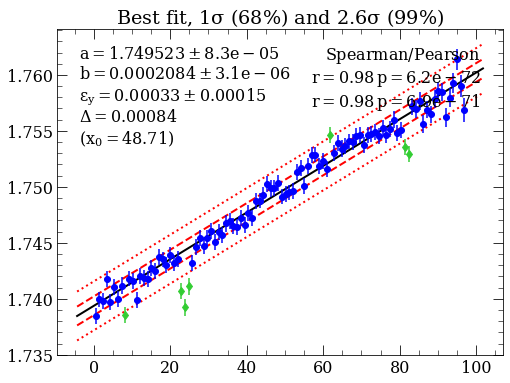

In [41]:
pmag = lts_linefit(time, mag, e_time, e_mag, pivot = np.median(time), frac = 0.95).ab
plt.autoscale()

sig_int:     0.0000      0.1624
Computing sig_int
sig_int:     0.0000      0.1624
sig_int:     0.0023     -0.5540
sig_int:     0.0005      0.1293
sig_int:     0.0014     -0.2603
sig_int:     0.0008      0.0070
sig_int:     0.0008     -0.0004
sig_int:     0.0008      0.0000
sig_int:     0.0008     -0.0002
Computing sig_int error
sig_int:     0.0008      0.1459
sig_int:     0.0023     -0.4081
sig_int:     0.0012     -0.0312
sig_int:     0.0011     -0.0005
sig_int:     0.0011      0.0000
Repeat at best fitting solution
sig_int:     0.0008      0.0000
################# Values and formal errors ################
 intercept:  -0.63216 +/- 0.00019
     slope:  9.21e-05 +/- 7.0e-06
   scatter:  0.00083 +/- 0.00032
Observed rms scatter: 0.0019
y = a + b*(x - pivot) with pivot = 48.71
Spearman r=0.82 and p=6.2e-26
Pearson r=0.78 and p=5.8e-22
##########################################################
seconds 17.37


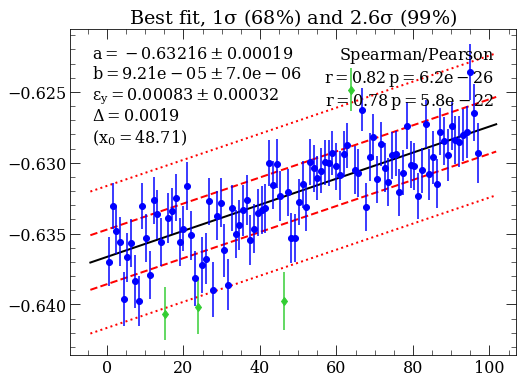

In [42]:
pcolor = lts_linefit(time, color, e_time, e_color, pivot = np.median(time), frac = 0.95).ab
plt.autoscale()

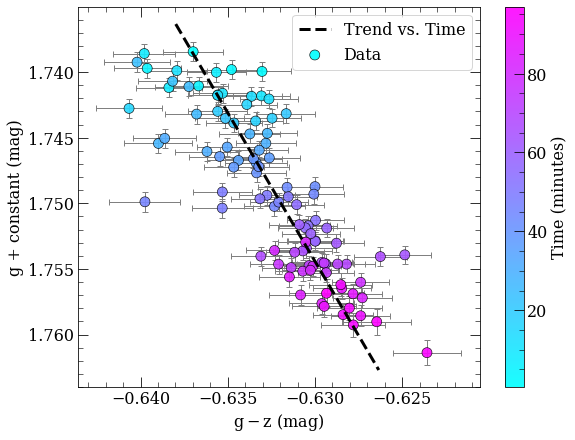

In [43]:
plt.figure(figsize = (9, 7))

plt.errorbar(color, mag, yerr = e_mag, xerr = e_color, linestyle = 'none',
           color = 'k', ecolor = 'gray', linewidth = 1, alpha = 1, 
              capsize = 3)

plt.scatter(color, mag, c = time, s = 100, cmap = 'cool', zorder = 100, label = 'Data', alpha = 0.9,
           linewidth = 0.65, edgecolor = 'k')


tgap = 15
tgrid = np.linspace(time.min() - tgap, time.max() + tgap, 1000)
mgrid = pmag[0] + pmag[1] * (tgrid - np.median(time))
cgrid = pcolor[0] + pcolor[1] * (tgrid - np.median(time))

plt.plot(cgrid, mgrid, 'k--', lw = 3, zorder = 200, label = 'Trend vs. Time')

plt.xlabel('$g-z$ (mag)')
plt.ylabel('g + constant (mag)')

plt.gca().invert_yaxis()
plt.legend()

cbar = plt.colorbar()
cbar.ax.set_ylabel('Time (minutes)')

#plt.xlim(-1.314, -1.274)

plt.savefig('fig/hipercam_cmd.pdf', bbox_inches = 'tight')

### Mie Scattering

In [65]:
import miepython

from scipy.integrate import quad

In [66]:
v_eff = 0.1

def nr(r, r_eff):
    return r ** ((1 - 3*v_eff) / v_eff) * np.exp((-r) / (r_eff * v_eff))

def reff(nr):
    numfunc = lambda r: r * np.pi * r**2 * nr(r, r_eff)
    num = quad(numfunc, 0, np.inf)[0]
    denomfunc = lambda r: np.pi * r**2 * nr(r, r_eff)
    denom = quad(denomfunc, 0, np.inf)[0]
    
    return num / denom

def veff(nr):
    r_eff = reff(nr)
    numfunc = lambda r: (r - r_eff)**2 * np.pi * r**2 * nr(r, r_eff)
    num = quad(numfunc, 0, np.inf)[0]
    denomfunc = lambda r: np.pi * r**2 * nr(r, r_eff)
    denom = r_eff**2 * quad(denomfunc, 0, np.inf)[0]
    
    return num / denom

def sigext(r, wl, dmre, dmim):
    x = 2 * np.pi * r / (wl * 1e-4)
    m = dmre(wl) - 1.0j * dmim(wl)
    qext, qsca, qback, g = miepython.mie(m, x)
    sig_ext = qext * np.pi * r**2
    return sig_ext

def mean_sigext_wl(r_eff, rmin, rmax, wl, dmre, dmim):
    numfunc = lambda r: nr(r, r_eff) * sigext(r, wl, dmre, dmim)
    num = quad(numfunc, rmin, rmax)[0]
    
    denomfunc = lambda r: nr(r, r_eff) 
    denom = quad(denomfunc, rmin, rmax)[0]
    
    return num / denom

mean_sigext = np.vectorize(mean_sigext_wl)

In [67]:
fwls = np.array([3580, 4754, 6204, 7698, 9665])
wlgrid = np.linspace(3050, 10000, 50)

In [68]:
rgrid = np.linspace(0.001 * 0.2, 1000 * 0.2, 10000)

In [69]:
def get_sigext_curve(rindex, r_eff):
    if isinstance(rindex, str):
        print('reading file')
        dust = np.genfromtxt('mie/' + rindex + '.txt', delimiter = '\t')
        N = len(dust)//2
        dust_lam = dust[1:N,0] * 1e4
        dust_mre = dust[1:N,1]
        dust_mim = dust[N+1:,1]
        dmre = interp1d(dust_lam, dust_mre)
        dmim = interp1d(dust_lam, dust_mim)
        
    elif isinstance(rindex, tuple):
        dmre = lambda wl: rindex[0]
        dmim = lambda wl: rindex[1]
        print('using numbers')
    else:
        print('invalid refractive index')
        
    rdist = nr(rgrid, r_eff)
    cumrdist = np.cumsum(rdist)
    cumrdist = cumrdist / np.max(cumrdist)
    rmin = interp1d(cumrdist, rgrid)(0.01)
    rmax = interp1d(cumrdist, rgrid)(0.99)
    dust_sigext = mean_sigext(r_eff, rmin, rmax, wlgrid, dmre, dmim)
    
    return dust_sigext

using numbers
using numbers
reading file
using numbers


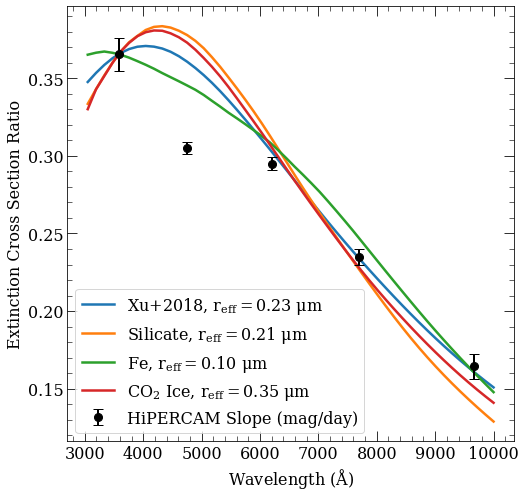

In [70]:
plt.figure(figsize = (8, 8))

plt.errorbar(fwls, slopes, yerr = e_slopes,
    linestyle = 'none', color = 'k', zorder = 100, marker = 'o', markersize = 8, 
            label = 'HiPERCAM Slope (mag/day)', linewidth = 2)


name = 'Xu+2018'
r_eff = 0.23
dust_sigext = get_sigext_curve((1.6, 0.1), r_eff) ## Xu 2020
norm_sigext = dust_sigext *  slopes[0] / scipy.interpolate.interp1d(wlgrid, dust_sigext)(fwls[0])
plt.plot(wlgrid, norm_sigext, lw = 2.5, label = '%s, $r_{eff} = %.2f\ \mu m$' % (name, r_eff), 
         linestyle = '-')

name = 'Silicate' # Draine +03
r_eff = 0.21
dust_sigext = get_sigext_curve((1.7, 0.03), r_eff)
norm_sigext = dust_sigext *  slopes[0] / scipy.interpolate.interp1d(wlgrid, dust_sigext)(fwls[0])
plt.plot(wlgrid, norm_sigext, lw = 2.5, label = '%s, $r_{eff} = %.2f\ \mu m$' % (name, r_eff), 
         linestyle = '-')

name = 'Fe'
r_eff = 0.096
dust_sigext = get_sigext_curve(name, r_eff)
norm_sigext = dust_sigext *  slopes[0] / scipy.interpolate.interp1d(wlgrid, dust_sigext)(fwls[0])
plt.plot(wlgrid, norm_sigext, lw = 2.5, label = '%s, $r_{eff} = %.2f\ \mu m$' % (name, r_eff), 
         linestyle = '-')

name = 'CO$_2$ Ice' # Warren 1986
r_eff = 0.35
dust_sigext = get_sigext_curve((1.4, 1e-5), r_eff)
norm_sigext = dust_sigext *  slopes[0] / scipy.interpolate.interp1d(wlgrid, dust_sigext)(fwls[0])
plt.plot(wlgrid, norm_sigext, lw = 2.5, label = '%s, $r_{eff} = %.2f\ \mu m$' % (name, r_eff), 
         linestyle = '-')

plt.legend()
plt.ylabel('Extinction Cross Section Ratio')
plt.xlabel('Wavelength ($\AA$)')

plt.savefig('fig/hipercam_extinction_materials.pdf', bbox_inches = 'tight')

using numbers
using numbers
using numbers


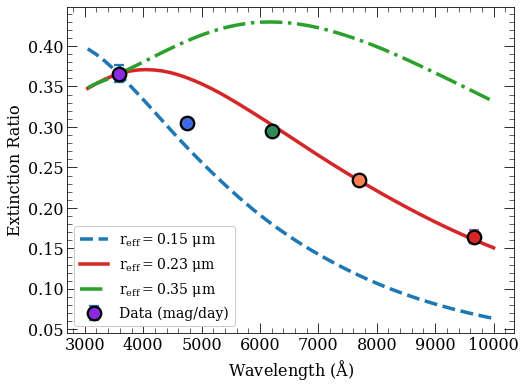

In [82]:
plt.figure(figsize = (8, 6))

labs = ['Data (mag/day)', None, None , None, None]

for ii in range(len(slopes)):
    plt.errorbar(fwls[ii], slopes[ii], yerr = e_slopes[ii],
        linestyle = 'none', mfc = list(color_dict.values())[ii], zorder = 100, marker = 'o', markersize = 13.5, 
                label = labs[ii], linewidth = 5, elinewidth = 3, mec = 'k', mew = 2.25)

n = 1.6
k = 0.1
reffs = [0.15, 0.23, 0.35]
colors = ['C0', 'tab:red', 'C2']
styles = ['--', '-', '-.']
name = 'CO$_2$ Ice' # Warren 1986
for ii,r_eff in enumerate(reffs):
    dust_sigext = get_sigext_curve((n, k), r_eff)
    norm_sigext = dust_sigext *  slopes[0] / scipy.interpolate.interp1d(wlgrid, dust_sigext)(fwls[0])
    plt.plot(wlgrid, norm_sigext, lw = 3.5, label = '$r_{eff} = %.2f\ \mu m$' % (r_eff), 
             linestyle = styles[ii], color = colors[ii])

plt.legend(fontsize = 14, framealpha = 1)
plt.ylabel('Extinction Ratio')
plt.xlabel('Wavelength ($\AA$)')

#plt.xlim(3000, 9000)

plt.savefig('fig/hipercam_extinction.pdf', bbox_inches = 'tight')

In [83]:
wlgrid

array([ 3050.        ,  3191.83673469,  3333.67346939,  3475.51020408,
        3617.34693878,  3759.18367347,  3901.02040816,  4042.85714286,
        4184.69387755,  4326.53061224,  4468.36734694,  4610.20408163,
        4752.04081633,  4893.87755102,  5035.71428571,  5177.55102041,
        5319.3877551 ,  5461.2244898 ,  5603.06122449,  5744.89795918,
        5886.73469388,  6028.57142857,  6170.40816327,  6312.24489796,
        6454.08163265,  6595.91836735,  6737.75510204,  6879.59183673,
        7021.42857143,  7163.26530612,  7305.10204082,  7446.93877551,
        7588.7755102 ,  7730.6122449 ,  7872.44897959,  8014.28571429,
        8156.12244898,  8297.95918367,  8439.79591837,  8581.63265306,
        8723.46938776,  8865.30612245,  9007.14285714,  9148.97959184,
        9290.81632653,  9432.65306122,  9574.48979592,  9716.32653061,
        9858.16326531, 10000.        ])

### Xu+18 Test

In [54]:
wlgrid = np.logspace(-1, 1, 10)*1e4

using numbers
using numbers
using numbers
using numbers


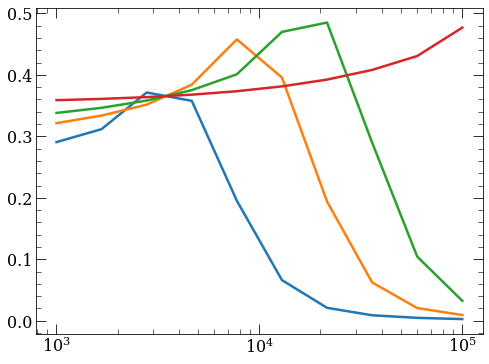

In [55]:
name = 'Xu+2018'
r_eff = 0.2
dust_sigext = get_sigext_curve((1.6, 0.1), r_eff) ## Xu 2020
norm_sigext = dust_sigext *  slopes[0] / scipy.interpolate.interp1d(wlgrid, dust_sigext)(fwls[0])

plt.plot(wlgrid, norm_sigext, lw = 2.5, label = '%s, $r_{eff} = %.2f\ \mu m$' % (name, r_eff), 
         linestyle = '-')

r_eff = 0.5
dust_sigext = get_sigext_curve((1.6, 0.1), r_eff) ## Xu 2020
norm_sigext = dust_sigext *  slopes[0] / scipy.interpolate.interp1d(wlgrid, dust_sigext)(fwls[0])

plt.plot(wlgrid, norm_sigext, lw = 2.5, label = '%s, $r_{eff} = %.2f\ \mu m$' % (name, r_eff), 
         linestyle = '-')

r_eff = 1
dust_sigext = get_sigext_curve((1.6, 0.1), r_eff) ## Xu 2020
norm_sigext = dust_sigext *  slopes[0] / scipy.interpolate.interp1d(wlgrid, dust_sigext)(fwls[0])

plt.plot(wlgrid, norm_sigext, lw = 2.5, label = '%s, $r_{eff} = %.2f\ \mu m$' % (name, r_eff), 
         linestyle = '-')

r_eff = 10
dust_sigext = get_sigext_curve((1.6, 0.1), r_eff) ## Xu 2020
norm_sigext = dust_sigext *  slopes[0] / scipy.interpolate.interp1d(wlgrid, dust_sigext)(fwls[0])

plt.plot(wlgrid, norm_sigext, lw = 2.5, label = '%s, $r_{eff} = %.2f\ \mu m$' % (name, r_eff), 
         linestyle = '-')

plt.xscale('log')

In [59]:
list(color_dict.values())

['blueviolet', 'royalblue', 'seagreen', 'coral', 'tab:red']